# Data Acquisition

## Overview

All data is at the daily level, represented as a volume weighted average.  Data is acquired all the way back to 2011, the longest period to obtain a reasonably complete dataset.  

The sections below will constitute a data dictionary for the columns utilized in this inquiry.

## US Equity Indices

Given the importance of equity markets to the health of the overall economy, as well as the media's obsession with their movements, daily time-series of the following were included:

- SP500: [SPX S&P 500 Index](https://us.spindices.com/indices/equity/sp-500) of large-cap US equities
- NASDAQCOM: [Nasdaq Composite Index](http://money.cnn.com/data/markets/nasdaq/) of large-cap US equities
- DJIA: [Dow Jones Industrial Average](https://quotes.wsj.com/index/DJIA) of US equities
- RU2000PR: [Russell 2000 Price Index](https://fred.stlouisfed.org/series/RU2000PR) of US equities

The `pandas_datareader.data` and `quandl` APIs were used to acquire this information.

## Traditional Currencies

The [St. Louis Federal Reserve's FRED API](https://fred.stlouisfed.org/) was accessed using the [`pandas_datareader.data`](https://pandas-datareader.readthedocs.io/en/latest/) API to gather currency exchange rates of the US Dollar against the Japanese Yen, the Euro, the Chinese Yuan, the Mexican Peso, and the Australian Dollar.

- DEXCHUS: [Chinese Yuan to USD](https://fred.stlouisfed.org/series/DEXCHUS)
- DEXJPUS: [Japanese Yen to USD](https://fred.stlouisfed.org/series/DEXJPUS)
- DEXUSEU: [USD to European Union's Euro](https://fred.stlouisfed.org/series/DEXUSEU)
- DEXMXUS: [Mexican New Pesos to USD](https://fred.stlouisfed.org/series/DEXMXUS)
- DEXUSAL: [USD to Australian Dollar](https://fred.stlouisfed.org/series/DEXUSAL)

## Debt Market Indicators

A ladder of bond market indicators are represented in the data in LIBOR rates at various maturities.  Specifically, LIBOR is included at overnight, 1-month, 3-month and 12-month maturities.  To (very crudely) represent the consumer and the corporate markets we also included indices representing high yield returns and prime corporate debt returns.

- USDONTD156N: [Overnight London Interbank Offered Rate (LIBOR](https://fred.stlouisfed.org/series/USDONTD156N) based on USD
- USD1MTD156N: [One Month London Interbank Offered Rate (LIBOR](https://fred.stlouisfed.org/series/USD1MTD156N) based on USD
- USD3MTD156N: [Three Month London Interbank Offered Rate (LIBOR](https://fred.stlouisfed.org/series/USD3MTD156N) based on USD
- USD12MD156N: [Twelve Month London Interbank Offered Rate (LIBOR](https://fred.stlouisfed.org/series/USD12MD156N) based on USD
- BAMLHYH0A0HYM2TRIV: [ICE BofAML US High Yield Total Return Index Value](https://fred.stlouisfed.org/series/BAMLHYH0A0HYM2TRIV)
- BAMLCC0A1AAATRIV: [ICE BofAML US Corp AAA Total Return Index Value](https://fred.stlouisfed.org/series/BAMLCC0A1AAATRIV)

These series were also acquired from the St. Louis Fed's FRED API.

## Commodity Prices

We chose to include series that represent the oil market and the gold market, two assets that are not strongly tied to the others mentioned.

- GOLDAMGBD228NLBM: [Gold Fixing Price 10:30 AM (London Time) in London Bullion Market, based on  USD](https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM)
- DCOILWTICO: [West Texas Intermediate (WTI) - Cushing Oklahoma](https://fred.stlouisfed.org/series/DCOILWTICO)

These series were also acquired from the St. Louis Fed's FRED API.

## Energy-Related Series

To ensure we are getting signal from the energy sector data on natural gas and energy sector volatility is gathered.  This data is alos acquired form teh St. Louis Fed's FRED API.

- MHHNGSP: [Henry Hub Natural Gas Spot Price](https://fred.stlouisfed.org/series/MHHNGSP)
- VXXLECLS: [CBOE Energy Sector ETF Volatility Index](https://fred.stlouisfed.org/series/VXXLECLS)

## Call FRED API

Below a simple function `get_fred_data` is defined to call the Saint Louis Fed's FRED API via pandas_datareader.  

In [ ]:
# Starting the data cleaning and pre-processing

## Generating in Calendar Attributes for Merge

To ensure adjustment for temporal factors a function `generate_calendar` is specified and used to merge in calendar attributes to the data.  These attributes, such as month or weekday, can be used in a machine learning model alongside the data gathered from the FRED API.

In [ ]:
import numpy as np
def generate_calendar(year, drop_index=False):
    '''
    Simple function to generate a calendar containing
    US holidays, weekdays and  holiday weeks.
    '''
    from pandas.tseries.offsets import YearEnd
    from pandas.tseries.holiday import USFederalHolidayCalendar

    start_date = pd.to_datetime('1/1/'+str(year))
    end_date = start_date + YearEnd()
    DAT = pd.date_range(str(start_date), str(end_date), freq='D')
    MO = [d.strftime('%B') for d in DAT]
    holidays = USFederalHolidayCalendar().holidays(start=start_date, end=end_date)

    cal_df = pd.DataFrame({'date':DAT, 'month':MO})
    cal_df['year'] = [format(d, '%Y') for d in DAT]
    cal_df['weekday'] = [format(d, '%A') for d in DAT]
    cal_df['is_weekday'] = cal_df.weekday.isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])
    cal_df['is_weekday'] = cal_df['is_weekday'].astype(int)
    cal_df['is_holiday'] = cal_df['date'].isin(holidays)
    cal_df['is_holiday'] = cal_df['is_holiday'].astype(int)
    cal_df['is_holiday_week'] = cal_df.is_holiday.rolling(window=7,center=True,min_periods=1).sum()
    cal_df['is_holiday_week'] = cal_df['is_holiday_week'].astype(int)

    if not drop_index: cal_df.set_index('date', inplace=True)

    return cal_df

def make_calendars(year_list, drop_index):
    cal_df = pd.DataFrame()
    for year in year_list:
        cal_df = cal_df.append(generate_calendar(year, drop_index=drop_index))
    return cal_df

year_list = [str(int(i)) for i in np.arange(2011, 2019)]
cal_df = make_calendars(year_list, drop_index=False)
cal_df.head()

month  year    weekday  is_weekday  is_holiday  is_holiday_week
date                                                                         
2011-01-01  January  2011   Saturday           0           0                0
2011-01-02  January  2011     Sunday           0           0                0
2011-01-03  January  2011     Monday           1           0                0
2011-01-04  January  2011    Tuesday           1           0                0
2011-01-05  January  2011  Wednesday           1           0                0

## Merge `cal_df` with Data & Fill Missing Values

The act of merging in calendar attributes for every day of each year since 2011 using an outer join introduces missing values.  In financial markets we can expect `NaN` values during weekends and holidays for exchanges such as DJIA, then other metrics are taken at a frequency other than daily.  Pandas' `pd.DataFrame.fillna` function is used in two subsequent steps, first using `method='bfill'` then using `method='ffill'`.  This action is taken as an attempt at conservatism and at avoiding complex data imputation methods.  It is likely not the most scientifically sound technique.  

In [ ]:
econ_df = econ_df.join(cal_df, how='outer')
econ_df = econ_df.fillna(method='bfill')
econ_df = econ_df.fillna(method='ffill')

## Drop Future Records Created by `cal_df`

In [ ]:
from datetime import datetime as dt
# drop future records introduced from the calendar function
before_future = pd.to_datetime(econ_df.index.values) <= dt.now()
econ_df = econ_df.loc[before_future]

## Acquire One-Hot Encodings

In order for `month`, `year` and `weekday` columns to be useful in a neural network we need to convert them to one-hot vectors.  Below the `pd.get_dummies` function is used to accomplish this.

In [ ]:
# acquire one-hot encodings
econ_df = pd.get_dummies(econ_df,
                         columns=['month', 'year', 'weekday'],
                         drop_first=True)

## Convert Columns to Lowercase

In [ ]:
econ_df.columns = [str.lower(s) for s in econ_df.columns]
print(econ_df.columns.tolist())

['sp500', 'nasdaqcom', 'djia', 'ru2000pr', 'bogmbasew', 'dexjpus', 'dexuseu', 'dexchus', 'dexusal', 'vixcls', 'usdontd156n', 'usd1mtd156n', 'usd3mtd156n', 'usd12md156n', 'bamlhyh0a0hym2triv', 'bamlcc0a1aaatriv', 'goldamgbd228nlbm', 'dcoilwtico', 'mhhngsp', 'vxxlecls', 'is_weekday', 'is_holiday', 'is_holiday_week', 'month_august', 'month_december', 'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 'month_september', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017', 'year_2018', 'weekday_monday', 'weekday_saturday', 'weekday_sunday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday']


In [ ]:
# Save original data to a dictionary
data = dict()
data['original'] = econ_df
econ_df.to_csv('econ_df.csv')

# Feature Engineering

Two methods were undertaken to reduce the noise and spread the signal thruogh time in the data.  Rather than using the raw price data we do the following:

- Melt the data such that only three columns exist: `date`, `variable`, and `value`.  
- Perform a split-apply-combine by grouping the data by `variable`, calculate a percent change, then calculate a rolling `window` mean of the percent change
- Spread the data back to its original shape, using the rolling `window` percent change as the new features

This technique is an attempt to be more sensitive to changes in a given market as opposed to the actual value at any given time.  Taking a rolling mean also spreads out any market movements that may be anomalous such that they are more in the ballpark.

## Melt `econ_df` on `date` Column

To simplify plotting and facility the split-apply-combine operation the `econ_df` is melted on the `date` column.  

In [ ]:
econ_df_melt = econ_df.copy()
econ_df_melt.reset_index(inplace=True)
econ_df_melt.rename(columns={'index': 'date'}, inplace=True)
econ_df_melt = econ_df_melt.melt('date')
econ_df_melt.head()

date variable    value
0 2011-01-01    sp500  1271.87
1 2011-01-02    sp500  1271.87
2 2011-01-03    sp500  1271.87
3 2011-01-04    sp500  1270.20
4 2011-01-05    sp500  1276.56

## Perform Split-Apply-Combine to Calculate Features

Below we define the `window`, then split `econ_df_melt` on the `variable` column (which contains the names of the original columns).  The list of `onehot_cols` are not subject to this calculation since they are binary.  

In [ ]:
onehot_cols = ['is_weekday', 'is_holiday', 'is_holiday_week',
               'month_august', 'month_december',
               'month_february', 'month_january', 'month_july',
               'month_june', 'month_march',
               'month_may', 'month_november', 'month_october',
               'month_september', 'year_2011',
               'year_2012', 'year_2013', 'year_2014', 'year_2015',
               'year_2016', 'year_2017',
               'year_2018', 'weekday_monday', 'weekday_saturday',
               'weekday_sunday', 'weekday_thursday',
               'weekday_tuesday', 'weekday_wednesday']

window = 30 #rolling avg
smooth_df = pd.DataFrame()
for name, df in econ_df_melt.groupby('variable'):
    if name not in onehot_cols:
        colname = 'rolling_'+str(window)+'_mean'
        df['pct_change'] = df['value'].pct_change()
        df[colname] = df['pct_change'].rolling(window=window).mean()
    else:
        df[colname] = df['value']
    smooth_df = smooth_df.append(df)

smooth_df.head()

date  pct_change  rolling_30_mean   value          variable
40275 2011-01-01         NaN              NaN  479.31  bamlcc0a1aaatriv
40276 2011-01-02    0.000000              NaN  479.31  bamlcc0a1aaatriv
40277 2011-01-03    0.000000              NaN  479.31  bamlcc0a1aaatriv
40278 2011-01-04   -0.000542              NaN  479.05  bamlcc0a1aaatriv
40279 2011-01-05   -0.007348              NaN  475.53  bamlcc0a1aaatriv

## Visualize Data

Below a time-series plot is produced for each continuous feature in the data.  On the right of each plot is an inverted histogram that gives us an idea of how percent changes vary (over a `window` period) for the given series.

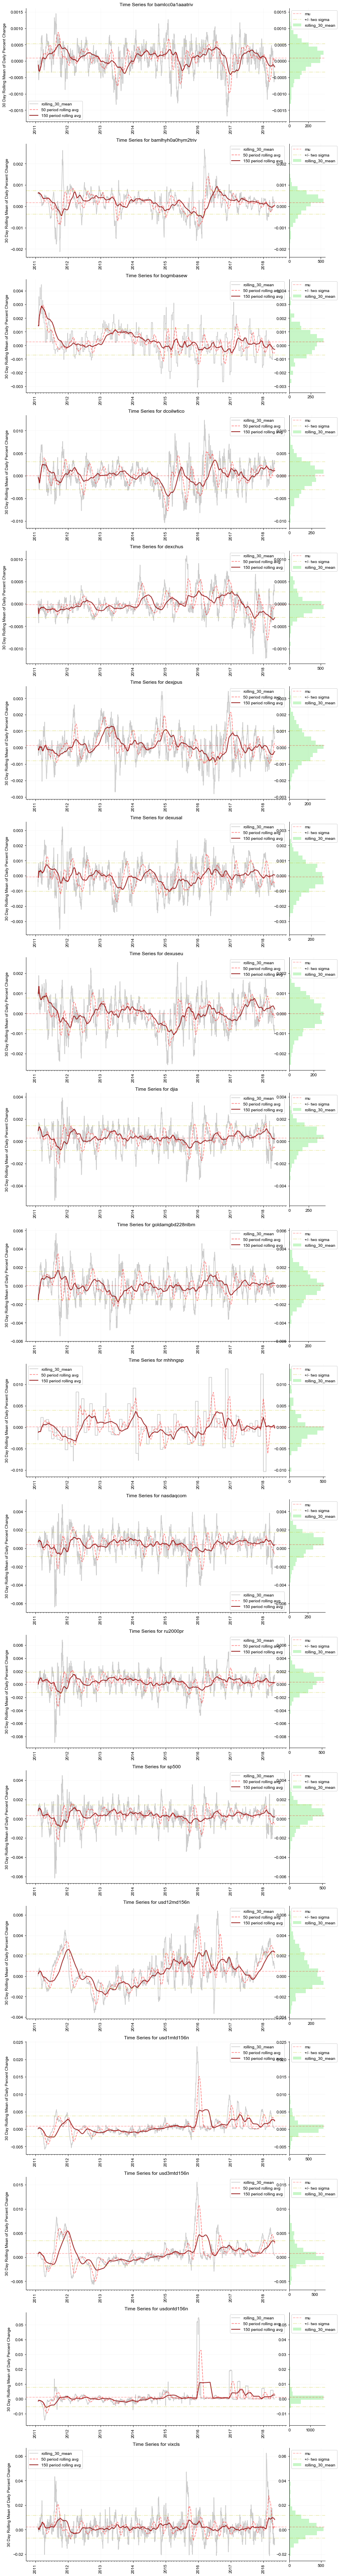

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')


def plot_tseries_over_group_with_histograms(df, xcol, ycol,
                                            grpcol, title_prepend='{}',
                                            labs=None, x_angle=0, labelpad=60,
                                            window=15, ignore_cols=[]):
    '''
    Function for plotting time series df[ycol] over datetime range df[xcol]
    using the unique_grp_vals contained in df[grpcol].unique().

     - df: pd.DataFrame containing datetime and series to plot
     - xcol: str of column name in df for datetime series
     - ycol: str of column name in df for tseries
     - grpcol: str of column name in df of group over which to plot
     - labs: dict of xlab, ylab
     - title_prepend: str containing "{}" that prepends group names in title
     - window: int for calculating rolling means of each series
     - ignore_cols: list of column names not to plot
    '''
    unique_grp_vals = df[grpcol].unique()
    nrows = len(unique_grp_vals) - len(ignore_cols)
    figsize = (13, 6 * nrows)
    fig, axes = plt.subplots(nrows, 1, figsize=figsize)
    title_prepend_hist = 'Histogram of ' + str(title_prepend)
    j = 0
    for i, grp in enumerate(unique_grp_vals):
        _df = df.loc[df[grpcol] == grp]
        if grp not in ignore_cols:
            _df = df.loc[df[grpcol] == grp]
            try:
                ax = axes[j]
                ax.plot(_df[xcol], _df[ycol], alpha=.2, color='black')
                ax.plot(_df[xcol], _df[ycol].rolling(window=window, min_periods=min(5, window)).mean(),
                        alpha=.5, color='r', label='{} period rolling avg'.format(window),
                        linestyle='--')
                longer_window = int(window * 3)
                ax.plot(_df[xcol], _df[ycol].rolling(window=longer_window, min_periods=5).mean(),
                        alpha=.8, color='darkred', label='{} period rolling avg'.format(longer_window),
                        linewidth=2)
                mu, sigma = _df[ycol].mean(), _df[ycol].std()
                ax.axhline(mu, linestyle='--', color='r', alpha=.3)
                ax.axhline(mu - sigma, linestyle='-.', color='y', alpha=.3)
                ax.axhline(mu + sigma, linestyle='-.', color='y', alpha=.3)
                ax.set_title(title_prepend.format(grp))
                ax.legend(loc='best')
                bottom, top = mu - 3*sigma, mu + 3*sigma
                ax.set_ylim((bottom, top))
                if labs is not None:
                    ax.set_xlabel(labs['xlab'])
                    ax.set_ylabel(labs['ylab'])
                ax.xaxis.labelpad = labelpad
                ax.xaxis.set_minor_locator(months)
                ax.grid(alpha=.1)
                if x_angle != 0:
                    for tick in ax.get_xticklabels():
                        tick.set_rotation(x_angle)

                divider = make_axes_locatable(ax)
                axHisty = divider.append_axes('right', 1.2, pad=0.1, sharey=ax)
                axHisty.grid(alpha=.1)
                axHisty.hist(_df[ycol].dropna(), orientation='horizontal', alpha=.5, color='lightgreen', bins=25)
                axHisty.axhline(mu, linestyle='--', color='r', label='mu', alpha=.3)
                axHisty.axhline(mu - sigma, linestyle='-.', color='y', label='+/- two sigma', alpha=.3)
                axHisty.axhline(mu + sigma, linestyle='-.', color='y', alpha=.3)
                axHisty.legend(loc='best')

                j += 1
            except IndexError:
                pass
        else:
            pass

    sns.set_style("whitegrid")
    sns.despine()
    plt.show()


title_prepend = 'Time Series for {}'
xcol = 'date'
ycol = colname # from the rolling mean of pct change
grpcol = 'variable'
labs = dict(xlab='',
            ylab=str(window)+' Day Rolling Mean of Daily Percent Change')

plot_tseries_over_group_with_histograms(smooth_df,
                                        xcol, ycol, grpcol,
                                        title_prepend, labs,
                                        x_angle=90,
                                        ignore_cols=onehot_cols,
                                        window=50)

## Reshape Data to Original Form

The data used for the visualization above was melted using `pd.melt`, so below we widen, or spread, the data back out to separate columns.  

In [ ]:
smooth_df = smooth_df.pivot(index='date',
                            columns='variable',
                            values=colname)
smooth_df.dropna(inplace=True)

smooth_df.head()

variable    bamlcc0a1aaatriv  bamlhyh0a0hym2triv  bogmbasew  dcoilwtico  \
date                                                                      
2011-01-31          0.000007            0.000589   0.001434   -0.000108   
2011-02-01         -0.000074            0.000620   0.001434   -0.000639   
2011-02-02         -0.000175            0.000663   0.001434   -0.000550   
2011-02-03         -0.000219            0.000622   0.001434    0.000117   
2011-02-04         -0.000162            0.000638   0.001434   -0.000800   

variable     dexchus   dexjpus   dexusal   dexuseu      djia  \
date                                                           
2011-01-31  0.000063  0.000181 -0.000720  0.000867  0.000634   
2011-02-01  0.000023 -0.000018 -0.000233  0.001056  0.001049   
2011-02-02 -0.000168  0.000121 -0.000430  0.001022  0.001054   
2011-02-03 -0.000254 -0.000181  0.000348  0.000882  0.001052   
2011-02-04 -0.000145 -0.000485  0.000471  0.001049  0.001044   

variable    goldamgbd228nlbm  is_holiday  is_holiday_week  is_weekday  \
date                                                                    
2011-01-31         -0.001722         0.0              0.0         1.0   
2011-02-01         -0.001622         0.0              0.0         1.0   
2011-02-02         -0.001634         0.0              0.0         1.0   
2011-02-03         -0.001746         0.0              0.0         1.0   
2011-02-04         -0.000832         0.0              0.0         1.0   

variable     mhhngsp  month_august  month_december  month_february  \
date                                                                 
2011-01-31 -0.002970           0.0             0.0             0.0   
2011-02-01  0.000000           0.0             0.0             1.0   
2011-02-02 -0.000978           0.0             0.0             1.0   
2011-02-03 -0.000978           0.0             0.0             1.0   
2011-02-04 -0.000978           0.0             0.0             1.0   

variable    month_january  month_july  month_june  month_march  month_may  \
date                                                                        
2011-01-31            1.0         0.0         0.0          0.0        0.0   
2011-02-01            0.0         0.0         0.0          0.0        0.0   
2011-02-02            0.0         0.0         0.0          0.0        0.0   
2011-02-03            0.0         0.0         0.0          0.0        0.0   
2011-02-04            0.0         0.0         0.0          0.0        0.0   

variable    month_november  month_october  month_september  nasdaqcom  \
date                                                                    
2011-01-31             0.0            0.0              0.0   0.000129   
2011-02-01             0.0            0.0              0.0   0.000760   
2011-02-02             0.0            0.0              0.0   0.000740   
2011-02-03             0.0            0.0              0.0   0.000920   
2011-02-04             0.0            0.0              0.0   0.000846   

variable    ru2000pr     sp500  usd12md156n  usd1mtd156n  usd3mtd156n  \
date                                                                    
2011-01-31 -0.000688  0.000384     0.000014    -0.000080     0.000173   
2011-02-01  0.000065  0.000940     0.000195     0.000304     0.000843   
2011-02-02 -0.000050  0.000849     0.000219     0.000304     0.000843   
2011-02-03  0.000585  0.000972     0.000327     0.000304     0.000843   
2011-02-04  0.000254  0.000901     0.000439     0.000193     0.000950   

variable    usdontd156n    vixcls  vxxlecls  weekday_monday  weekday_saturday  \
date                                                                            
2011-01-31    -0.001591  0.004710       0.0             1.0               0.0   
2011-02-01    -0.001493  0.001467       0.0             0.0               0.0   
2011-02-02    -0.001634  0.000843       0.0             0.0               0.0   
2011-02-03    -0.001351  0.000103       0.0          

## Visualize Scatterplot Matrix

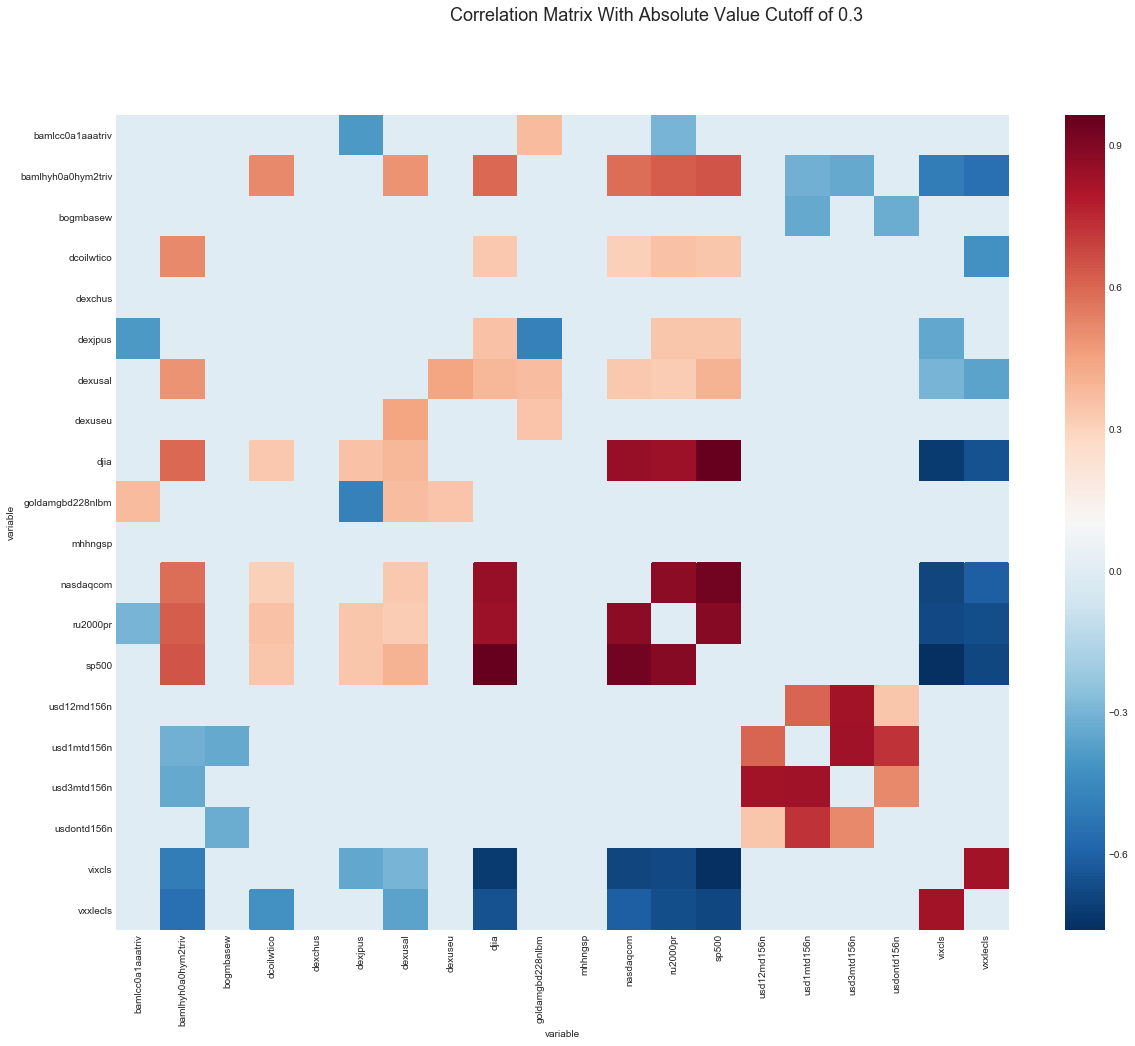

variable            bamlcc0a1aaatriv  bamlhyh0a0hym2triv  bogmbasew  \
variable                                                              
bamlcc0a1aaatriv            0.000000            0.000000   0.000000   
bamlhyh0a0hym2triv          0.000000            0.000000   0.000000   
bogmbasew                   0.000000            0.000000   0.000000   
dcoilwtico                  0.000000            0.513170   0.000000   
dexchus                     0.000000            0.000000   0.000000   
dexjpus                    -0.395618            0.000000   0.000000   
dexusal                     0.000000            0.490484   0.000000   
dexuseu                     0.000000            0.000000   0.000000   
djia                        0.000000            0.593667   0.000000   
goldamgbd228nlbm            0.376007            0.000000   0.000000   
mhhngsp                     0.000000            0.000000   0.000000   
nasdaqcom                   0.000000            0.584130   0.000000   
ru2000pr                   -0.301549            0.621835   0.000000   
sp500                       0.000000            0.641296   0.000000   
usd12md156n                 0.000000            0.000000   0.000000   
usd1mtd156n                 0.000000           -0.311157  -0.337298   
usd3mtd156n                 0.000000           -0.338786   0.000000   
usdontd156n                 0.000000            0.000000  -0.324681   
vixcls                      0.000000           -0.499565   0.000000   
vxxlecls                    0.000000           -0.548938   0.000000   

variable            dcoilwtico  dexchus   dexjpus   dexusal   dexuseu  \
variable                                                                
bamlcc0a1aaatriv      0.000000      0.0 -0.395618  0.000000  0.000000   
bamlhyh0a0hym2triv    0.513170      0.0  0.000000  0.490484  0.000000   
bogmbasew             0.000000      0.0  0.000000  0.000000  0.000000   
dcoilwtico            0.000000      0.0  0.000000  0.000000  0.000000   
dexchus               0.000000      0.0  0.000000  0.000000  0.000000   
dexjpus               0.000000      0.0  0.000000  0.000000  0.000000   
dexusal               0.000000      0.0  0.000000  0.000000  0.439638   
dexuseu               0.000000      0.0  0.000000  0.439638  0.000000   
djia                  0.333159      0.0  0.355592  0.385466  0.000000   
goldamgbd228nlbm      0.000000      0.0 -0.481853  0.368842  0.348541   
mhhngsp               0.000000      0.0  0.000000  0.000000  0.000000   
nasdaqcom             0.309218      0.0  0.000000  0.335334  0.000000   
ru2000pr              0.356003      0.0  0.340862  0.320768  0.000000   
sp500                 0.341511      0.0  0.337677  0.399681  0.000000   
usd12md156n           0.000000      0.0  0.000000  0.000000  0.000000   
usd1mtd156n           0.000000      0.0  0.000000  0.000000  0.000000   
usd3mtd156n           0.000000      0.0  0.000000  0.000000  0.000000   
usdontd156n           0.000000      0.0  0.000000  0.000000  0.000000   
vixcls                0.000000      0.0 -0.347499 -0.301673  0.000000   
vxxlecls             -0.423184      0.0  0.000000 -0.358413  0.000000   

variable                djia  goldamgbd228nlbm  mhhngsp  nasdaqcom  ru2000pr  \
variable                                                                       
bamlcc0a1aaatriv    0.000000          0.376007      0.0   0.000000 -0.301549   
bamlhyh0a0hym2triv  0.593667          0.000000      0.0   0.584130  0.621835   
bogmbasew           0.000000          0.000000      0.0   0.000000  0.000000   
dcoilwtico          0.333159          0.000000      0.0   0.309218  0.356003   
dexchus             0.000000          0.000000      0.0   0.000000  0.000000   
dexjpus             0.355592         -0.481853      0.0   0.000000  0.340862   
dexusal             0.385466          0.368842      0.0   0.335334  0.320768   
dexuseu             0.000000          0.348541      0.0   0.000000  0.000000   
djia                0.000000  

In [ ]:
viz_cols = ['bamlcc0a1aaatriv', 'bamlhyh0a0hym2triv', 'bogmbasew', 'dcoilwtico',
           'dexchus', 'dexjpus', 'dexusal', 'dexuseu', 'djia', 'goldamgbd228nlbm',
           'mhhngsp', 'nasdaqcom', 'ru2000pr', 'sp500', 'usd12md156n', 'usd1mtd156n',
           'usd3mtd156n', 'usdontd156n', 'vixcls', 'vxxlecls']

def correlation_heatmap(df, cutoff=None, title=''):
    df_corr = df.corr('pearson')
    np.fill_diagonal(df_corr.values, 0)
    if cutoff != None:
        for col in df_corr.columns:
            df_corr.loc[df_corr[col].abs() <= cutoff, col] = 0
    fig, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(df_corr, ax=ax, cmap='RdBu_r')
    plt.suptitle(title, size=18)
    plt.show()
    return df_corr


cutoff = .3
correlation_heatmap(smooth_df[viz_cols],
                    cutoff, 'Correlation Matrix With Absolute Value Cutoff of {}'.format(cutoff))

# Predicting Price of Crude Oil

The target we are attempting to predict is `dcoilwtico`, or WTI Crude Oil.  In order to be able to predict a value in the future we need to shift the $Y$ variable back in time, specifically by `window` periods.  This ensures that the label `window` days in the future is associated with observable attributes of the economy today (specifically the average of the rolling `window` averages of each vector's daily percent change).  

## Mapping in Actual `dcoilwtico` Prices to `smooth_df`

Since we have abstracted away from the original dataset we need to map in the labels to the `smooth_df` before splitting the data into X, Y, train and test sets.  

In [ ]:
# specify y column name
y_col = 'dcoilwtico'

# map the values to the corresponding dates
# in the moving averages dataset
y_dict = econ_df[y_col].to_dict()
smooth_df[y_col] = smooth_df.index.values
smooth_df[y_col] = smooth_df[y_col].map(y_dict)

# shift back -window so we are predicting +window in future
smooth_df[y_col] = smooth_df[y_col].shift(-window)
smooth_df.dropna(inplace=True)

# write to disk
fname = './data/smooth_df_'+str(window)+'_mean.csv'
smooth_df.to_csv(fname)
data['smooth_df'] = smooth_df
smooth_df.head()

variable    bamlcc0a1aaatriv  bamlhyh0a0hym2triv  bogmbasew  dcoilwtico  \
date                                                                      
2011-01-31          0.000007            0.000589   0.001434      102.27   
2011-02-01         -0.000074            0.000620   0.001434      101.92   
2011-02-02         -0.000175            0.000663   0.001434      104.34   
2011-02-03         -0.000219            0.000622   0.001434      105.37   
2011-02-04         -0.000162            0.000638   0.001434      105.37   

variable     dexchus   dexjpus   dexusal   dexuseu      djia  \
date                                                           
2011-01-31  0.000063  0.000181 -0.000720  0.000867  0.000634   
2011-02-01  0.000023 -0.000018 -0.000233  0.001056  0.001049   
2011-02-02 -0.000168  0.000121 -0.000430  0.001022  0.001054   
2011-02-03 -0.000254 -0.000181  0.000348  0.000882  0.001052   
2011-02-04 -0.000145 -0.000485  0.000471  0.001049  0.001044   

variable    goldamgbd228nlbm  is_holiday  is_holiday_week  is_weekday  \
date                                                                    
2011-01-31         -0.001722         0.0              0.0         1.0   
2011-02-01         -0.001622         0.0              0.0         1.0   
2011-02-02         -0.001634         0.0              0.0         1.0   
2011-02-03         -0.001746         0.0              0.0         1.0   
2011-02-04         -0.000832         0.0              0.0         1.0   

variable     mhhngsp  month_august  month_december  month_february  \
date                                                                 
2011-01-31 -0.002970           0.0             0.0             0.0   
2011-02-01  0.000000           0.0             0.0             1.0   
2011-02-02 -0.000978           0.0             0.0             1.0   
2011-02-03 -0.000978           0.0             0.0             1.0   
2011-02-04 -0.000978           0.0             0.0             1.0   

variable    month_january  month_july  month_june  month_march  month_may  \
date                                                                        
2011-01-31            1.0         0.0         0.0          0.0        0.0   
2011-02-01            0.0         0.0         0.0          0.0        0.0   
2011-02-02            0.0         0.0         0.0          0.0        0.0   
2011-02-03            0.0         0.0         0.0          0.0        0.0   
2011-02-04            0.0         0.0         0.0          0.0        0.0   

variable    month_november  month_october  month_september  nasdaqcom  \
date                                                                    
2011-01-31             0.0            0.0              0.0   0.000129   
2011-02-01             0.0            0.0              0.0   0.000760   
2011-02-02             0.0            0.0              0.0   0.000740   
2011-02-03             0.0            0.0              0.0   0.000920   
2011-02-04             0.0            0.0              0.0   0.000846   

variable    ru2000pr     sp500  usd12md156n  usd1mtd156n  usd3mtd156n  \
date                                                                    
2011-01-31 -0.000688  0.000384     0.000014    -0.000080     0.000173   
2011-02-01  0.000065  0.000940     0.000195     0.000304     0.000843   
2011-02-02 -0.000050  0.000849     0.000219     0.000304     0.000843   
2011-02-03  0.000585  0.000972     0.000327     0.000304     0.000843   
2011-02-04  0.000254  0.000901     0.000439     0.000193     0.000950   

variable    usdontd156n    vixcls  vxxlecls  weekday_monday  weekday_saturday  \
date                                                                            
2011-01-31    -0.001591  0.004710       0.0             1.0               0.0   
2011-02-01    -0.001493  0.001467       0.0             0.0               0.0   
2011-02-02    -0.001634  0.000843       0.0             0.0               0.0   
2011-02-03    -0.001351  0.000103       0.0          

## Split & Scale

Here we use `sklearn.preprocessing.StandardScaler` to center the `X_cols` data around zero.  Note that the test data is transformed based on the training data.

In [ ]:
# Prepocessrocess data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def split_scale(df, X_cols, y_col, norm_cols=None, train_size=.7):
    X = df[X_cols]
    Y = df[y_col]
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=train_size)
    std = StandardScaler()
    if norm_cols is not None:
        std.fit(xtrain[norm_cols])
        xtrain[norm_cols] = std.transform(xtrain[norm_cols])
        xtest[norm_cols] = std.transform(xtest[norm_cols])
        xtrain, xtest = xtrain.as_matrix(), xtest.as_matrix()
    else:
        std.fit(xtrain)
        xtrain = std.transform(xtrain)
        xtest = std.transform(xtest)

    return xtrain, ytrain, xtest, ytest

norm_cols = [col for col in smooth_df.columns if col not in onehot_cols+[y_col]]
X_cols = [col for col in smooth_df.columns if col != y_col]
X_train, y_train, X_test, y_test = split_scale(smooth_df,
                                               X_cols, y_col,
                                               norm_cols=norm_cols,
                                               train_size=.7)

## Split off 50% of Test Data for Final Testing

Since we are burning through the `X_val` and `y_val` data during training we must preserve some data to test our model after it has been tarined.  For this reason we are splitting the test set in half for final testing on each model

In [ ]:
# split test set to val and test
cutoff_ix = X_test.shape[0] // 2
X_val, y_val = X_test[:cutoff_ix], y_test[:cutoff_ix]
X_test, y_test = X_test[cutoff_ix:], y_test[cutoff_ix:]

## Define `plot_loss`

The function below is used to plot the loss function of each `history.history` object generated in the Keras training process.  

In [ ]:
import numpy as np
import pandas as pd
import keras
import time # add decorator to time functions
from functools import wraps # add decorator to time functions
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


def plot_loss(history_obj, width=11):
    '''
    Leans on Keras' history.history object to visualize fit of model.
    '''
    plt.clf()
    loss = history_obj['loss']
    val_loss = history_obj['val_loss']
    d_loss = np.subtract(loss, val_loss)
    epochs = range(1, len(loss)+1)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(width, 6))
    ax.plot(epochs, loss, 'g', label='Training Loss', linestyle='--')
    ax.plot(epochs, val_loss, 'b', label='Validation Loss', linestyle='-.')
    ax.set_title('Training & Validation Loss')
    ax.set_xlabel('')
    ax.set_ylabel('Loss')
    ax.grid(alpha=0.3)
    ax.legend(loc='best')
    sns.despine()
    plt.suptitle('Training vs. Validation of Sequential Network Model Over Various Epochs')

    fig2, ax2 = plt.subplots(figsize=(width, 3))
    ax2.plot(epochs, d_loss, c='black', label='train_loss - val_loss')
    ax2.grid(alpha=0.3)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss Differential (Train-Val)')
    ax2.legend(loc='best')
    ax2.axhline(0, c='black', linestyle=':')
    ax2.set_title('Difference of Curves Above')

    sns.despine()
    plt.show()
    return None

Using TensorFlow backend.


## Perform Grid Search on Hyperparameters

First a simple function `simple_feedforward_model` is defined.  This function makes it easier to generate a simple densely connected model that enables various values for regularization, dropout, number of layers, and number of units per layer.  It could also be used, although it was not in this case, to vary the loss function, activation function, and optimizer.

Next a range of parameters are identified for `reg`, `dropout`, `num_neurons`, and `num_dense_layers`.  These ranges are then iterated over, such that all permutations are accounted for, and a model with the iteration's specifications is created, trained and tested.  Keras' callback `EarlyStopping` is used with `patience=1` in order to stop training models after convergence has occurred.

As the grid search is performed the results of each model are saved into a Python dictionary called `model_dict` for analysis after-the-fact.  

***Note:  If you are not using a GPU it is recommended that you decrease the number of parameters to search over.  This search takes hours on a NVIDIA 980 GPU card.***

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9283695981819652805
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3234522726
locality {
  bus_id: 1
}
incarnation: 2709701482731429392
physical_device_desc: "device: 0, name: GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 00373: early stopping
Model ID: 001_0.005_0.0_2_16
--------------------------------------------------------------------------------
R-squared on training data = 0.8849
R-squared on validation data = 0.8662
R-squared on testing data = 0.8526
--------------------------------------------------------------------------------

                    Model # 1
                    Fully Connected Model w/ Dropout & Regularization 
                     - Regularizer Rate:    0.0050000
                     - Dropout Rate:        0.000
                     - Number Dense Layers: 1
                     - Neurons per Layer:   16
                     



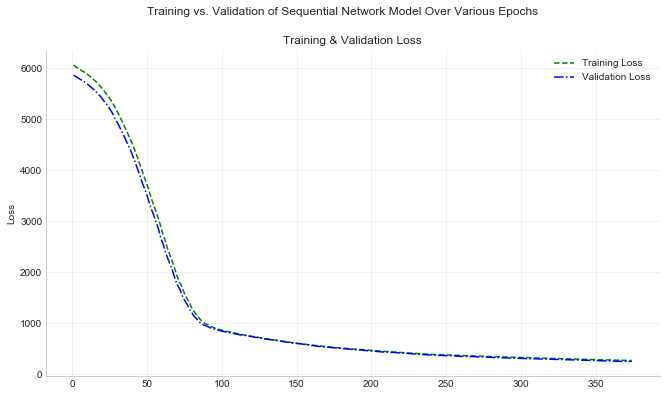

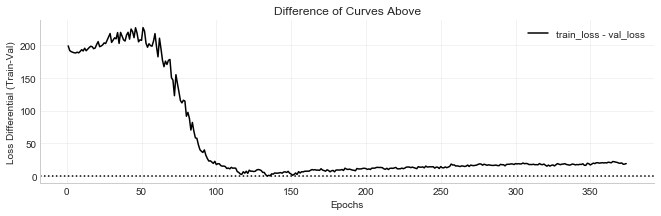

Epoch 00360: early stopping
Model ID: 002_0.001_0.0_2_16
--------------------------------------------------------------------------------
R-squared on training data = 0.8797
R-squared on validation data = 0.8545
R-squared on testing data = 0.8506
--------------------------------------------------------------------------------

                    Model # 2
                    Fully Connected Model w/ Dropout & Regularization 
                     - Regularizer Rate:    0.0010000
                     - Dropout Rate:        0.000
                     - Number Dense Layers: 1
                     - Neurons per Layer:   16
                     



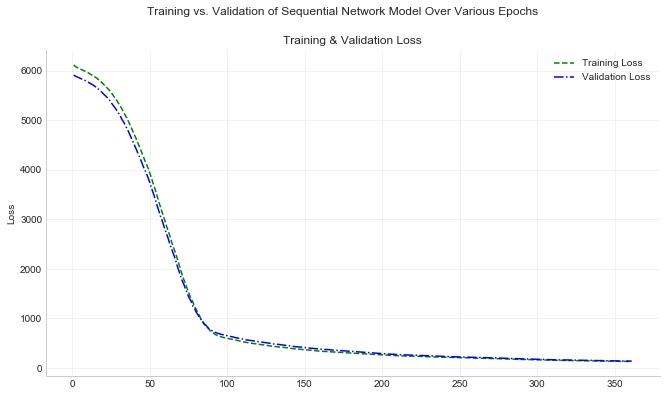

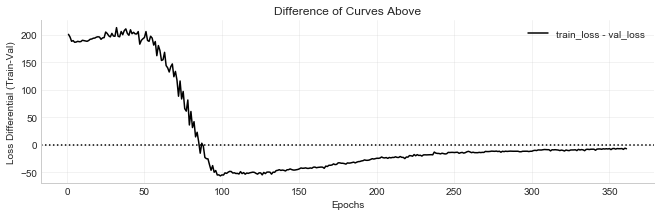

Epoch 00330: early stopping
Model ID: 003_0.0005_0.0_2_16
--------------------------------------------------------------------------------
R-squared on training data = 0.8787
R-squared on validation data = 0.8509
R-squared on testing data = 0.8505
--------------------------------------------------------------------------------

                    Model # 3
                    Fully Connected Model w/ Dropout & Regularization 
                     - Regularizer Rate:    0.0005000
                     - Dropout Rate:        0.000
                     - Number Dense Layers: 1
                     - Neurons per Layer:   16
                     



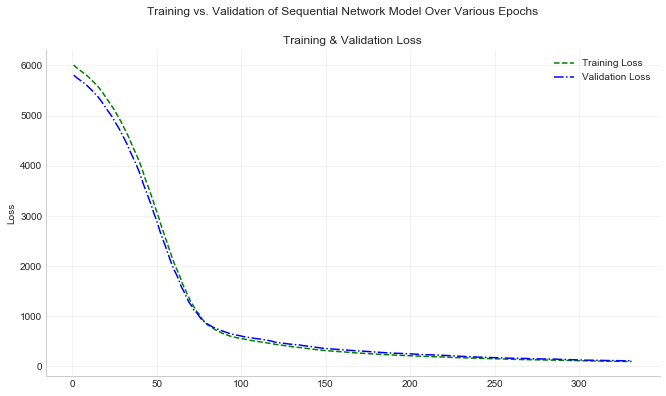

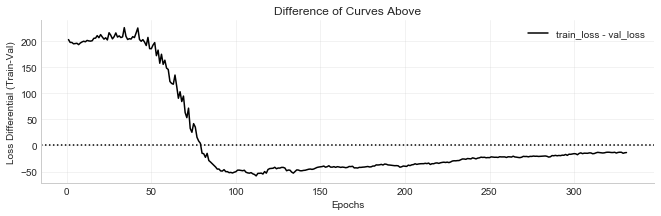

Epoch 00251: early stopping
Model ID: 004_0.005_0.1_2_16
--------------------------------------------------------------------------------
R-squared on training data = 0.7110
R-squared on validation data = 0.6472
R-squared on testing data = 0.6331
--------------------------------------------------------------------------------
Epoch 00235: early stopping
Model ID: 005_0.001_0.1_2_16
--------------------------------------------------------------------------------
R-squared on training data = 0.6403
R-squared on validation data = 0.5877
R-squared on testing data = 0.5569
--------------------------------------------------------------------------------
Epoch 00256: early stopping
Model ID: 006_0.0005_0.1_2_16
--------------------------------------------------------------------------------
R-squared on training data = 0.7974
R-squared on validation data = 0.7457
R-squared on testing data = 0.7594
--------------------------------------------------------------------------------
Epoch 00173: ea

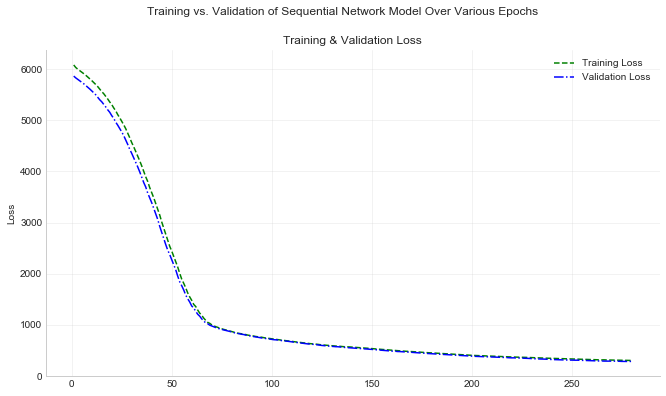

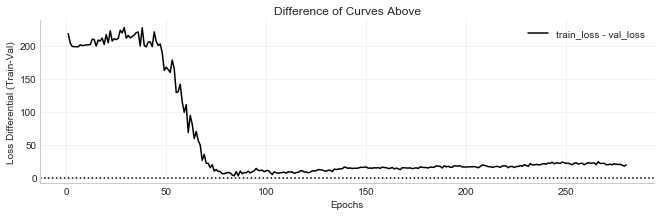

Epoch 00313: early stopping
Model ID: 014_0.001_0.0_2_22
--------------------------------------------------------------------------------
R-squared on training data = 0.8783
R-squared on validation data = 0.8522
R-squared on testing data = 0.8481
--------------------------------------------------------------------------------

                    Model # 14
                    Fully Connected Model w/ Dropout & Regularization 
                     - Regularizer Rate:    0.0010000
                     - Dropout Rate:        0.000
                     - Number Dense Layers: 1
                     - Neurons per Layer:   22
                     



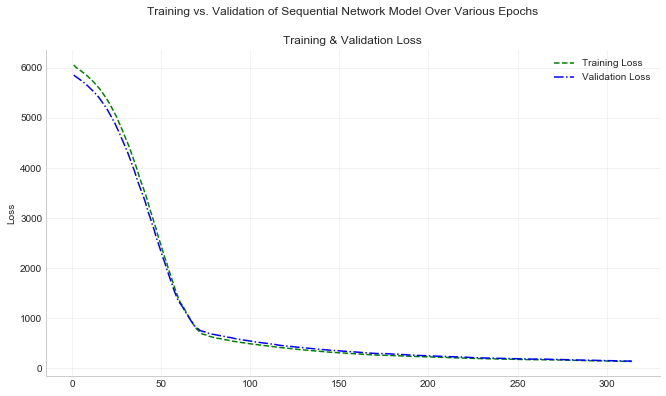

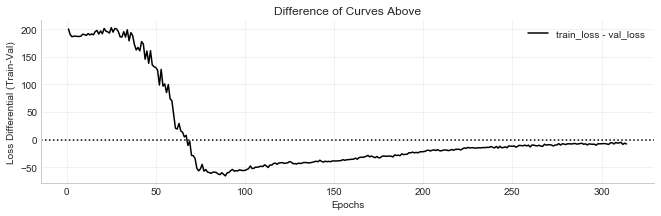

Epoch 00207: early stopping
Model ID: 015_0.0005_0.0_2_22
--------------------------------------------------------------------------------
R-squared on training data = 0.8067
R-squared on validation data = 0.7599
R-squared on testing data = 0.7542
--------------------------------------------------------------------------------
Epoch 00270: early stopping
Model ID: 016_0.005_0.1_2_22
--------------------------------------------------------------------------------
R-squared on training data = 0.8411
R-squared on validation data = 0.8019
R-squared on testing data = 0.7974
--------------------------------------------------------------------------------
Epoch 00180: early stopping
Model ID: 017_0.001_0.1_2_22
--------------------------------------------------------------------------------
R-squared on training data = 0.7437
R-squared on validation data = 0.7189
R-squared on testing data = 0.6766
--------------------------------------------------------------------------------
Epoch 00207: ea

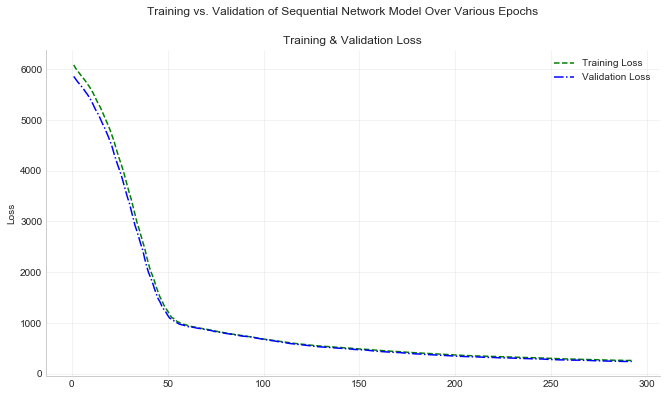

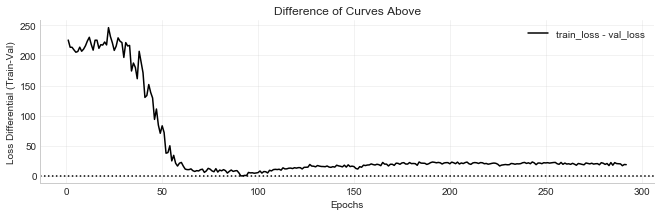

Epoch 00218: early stopping
Model ID: 026_0.001_0.0_2_28
--------------------------------------------------------------------------------
R-squared on training data = 0.8584
R-squared on validation data = 0.8297
R-squared on testing data = 0.8188
--------------------------------------------------------------------------------

                    Model # 26
                    Fully Connected Model w/ Dropout & Regularization 
                     - Regularizer Rate:    0.0010000
                     - Dropout Rate:        0.000
                     - Number Dense Layers: 1
                     - Neurons per Layer:   28
                     



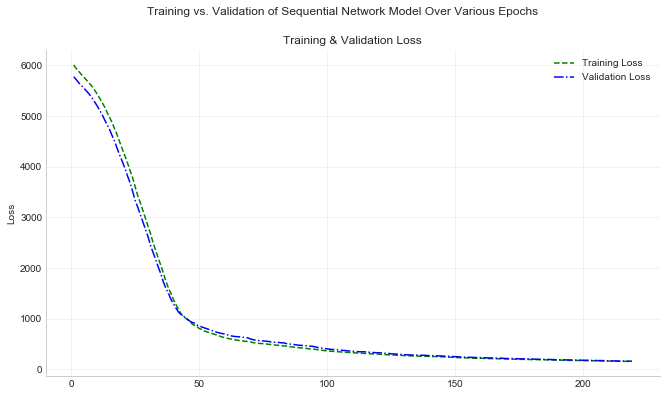

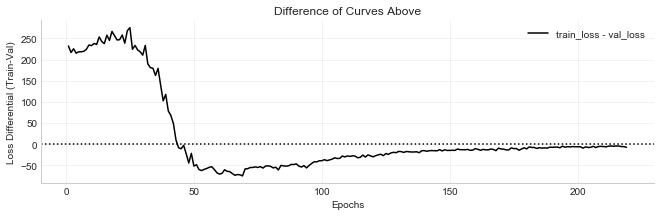

Epoch 00171: early stopping
Model ID: 027_0.0005_0.0_2_28
--------------------------------------------------------------------------------
R-squared on training data = 0.7871
R-squared on validation data = 0.7461
R-squared on testing data = 0.7410
--------------------------------------------------------------------------------
Epoch 00250: early stopping
Model ID: 028_0.005_0.1_2_28
--------------------------------------------------------------------------------
R-squared on training data = 0.8809
R-squared on validation data = 0.8562
R-squared on testing data = 0.8487
--------------------------------------------------------------------------------

                    Model # 28
                    Fully Connected Model w/ Dropout & Regularization 
                     - Regularizer Rate:    0.0050000
                     - Dropout Rate:        0.100
                     - Number Dense Layers: 1
                     - Neurons per Layer:   28
                     



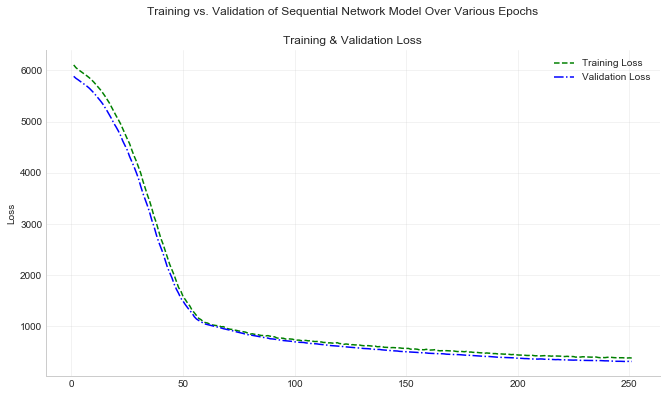

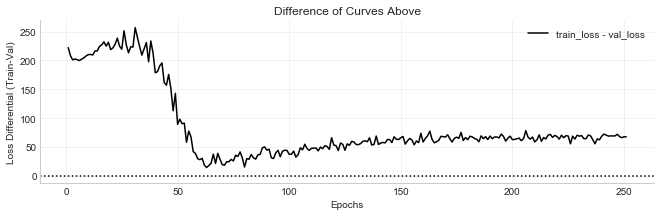

Epoch 00252: early stopping
Model ID: 029_0.001_0.1_2_28
--------------------------------------------------------------------------------
R-squared on training data = 0.8443
R-squared on validation data = 0.8042
R-squared on testing data = 0.8060
--------------------------------------------------------------------------------

                    Model # 29
                    Fully Connected Model w/ Dropout & Regularization 
                     - Regularizer Rate:    0.0010000
                     - Dropout Rate:        0.100
                     - Number Dense Layers: 1
                     - Neurons per Layer:   28
                     



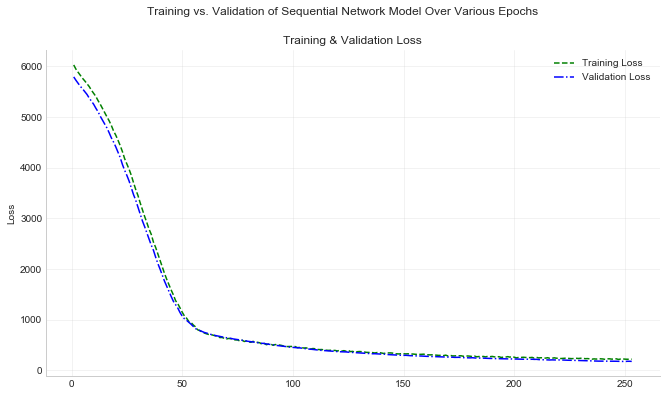

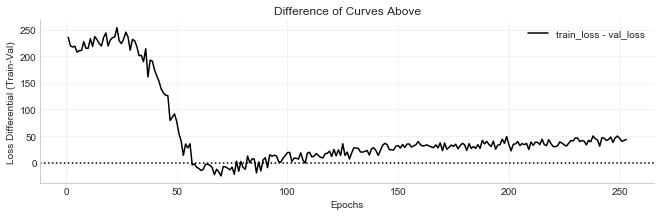

Epoch 00204: early stopping
Model ID: 030_0.0005_0.1_2_28
--------------------------------------------------------------------------------
R-squared on training data = 0.8245
R-squared on validation data = 0.7852
R-squared on testing data = 0.7674
--------------------------------------------------------------------------------
Epoch 00155: early stopping
Model ID: 031_0.005_0.2_2_28
--------------------------------------------------------------------------------
R-squared on training data = 0.6537
R-squared on validation data = 0.6040
R-squared on testing data = 0.5597
--------------------------------------------------------------------------------
Epoch 00157: early stopping
Model ID: 032_0.001_0.2_2_28
--------------------------------------------------------------------------------
R-squared on training data = 0.7181
R-squared on validation data = 0.6654
R-squared on testing data = 0.6441
--------------------------------------------------------------------------------
Epoch 00188: ea

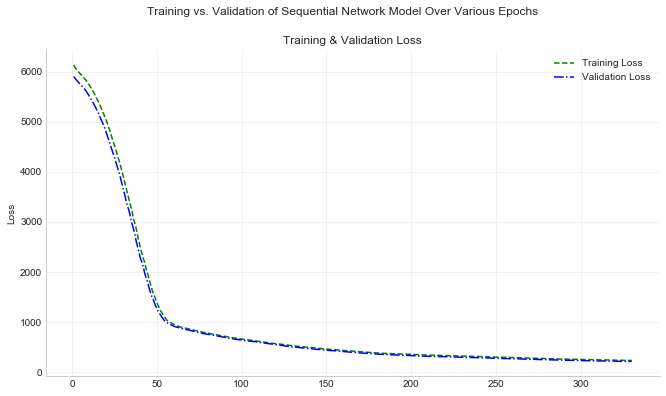

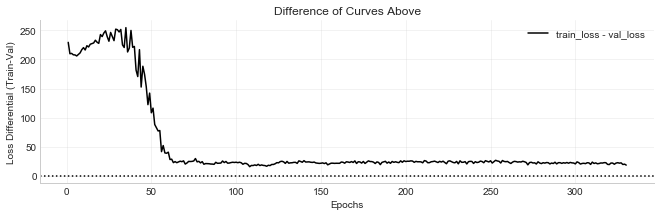

Epoch 00192: early stopping
Model ID: 038_0.001_0.0_2_34
--------------------------------------------------------------------------------
R-squared on training data = 0.8644
R-squared on validation data = 0.8372
R-squared on testing data = 0.8320
--------------------------------------------------------------------------------

                    Model # 38
                    Fully Connected Model w/ Dropout & Regularization 
                     - Regularizer Rate:    0.0010000
                     - Dropout Rate:        0.000
                     - Number Dense Layers: 1
                     - Neurons per Layer:   34
                     



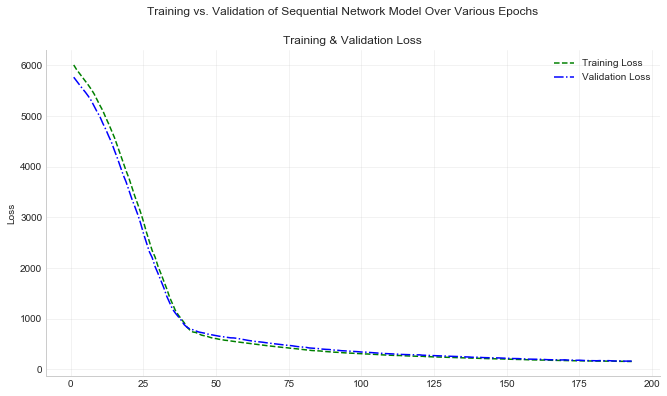

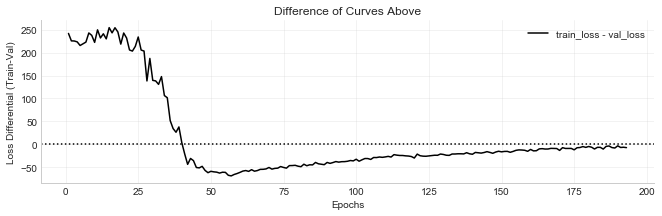

Epoch 00161: early stopping
Model ID: 039_0.0005_0.0_2_34
--------------------------------------------------------------------------------
R-squared on training data = 0.8149
R-squared on validation data = 0.7828
R-squared on testing data = 0.7773
--------------------------------------------------------------------------------
Epoch 00151: early stopping
Model ID: 040_0.005_0.1_2_34
--------------------------------------------------------------------------------
R-squared on training data = 0.7690
R-squared on validation data = 0.7235
R-squared on testing data = 0.7109
--------------------------------------------------------------------------------
Epoch 00226: early stopping
Model ID: 041_0.001_0.1_2_34
--------------------------------------------------------------------------------
R-squared on training data = 0.8924
R-squared on validation data = 0.8711
R-squared on testing data = 0.8719
--------------------------------------------------------------------------------

              

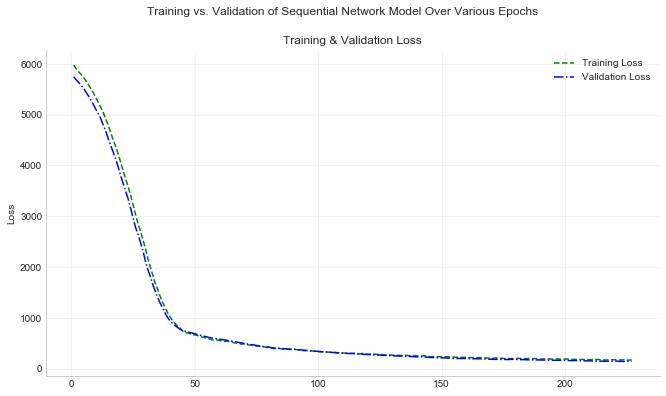

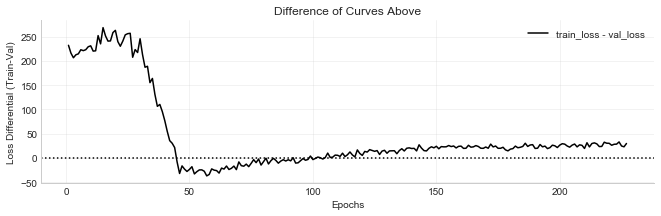

Epoch 00196: early stopping
Model ID: 042_0.0005_0.1_2_34
--------------------------------------------------------------------------------
R-squared on training data = 0.8242
R-squared on validation data = 0.7905
R-squared on testing data = 0.7883
--------------------------------------------------------------------------------
Epoch 00195: early stopping
Model ID: 043_0.005_0.2_2_34
--------------------------------------------------------------------------------
R-squared on training data = 0.8409
R-squared on validation data = 0.8099
R-squared on testing data = 0.7969
--------------------------------------------------------------------------------
Epoch 00218: early stopping
Model ID: 044_0.001_0.2_2_34
--------------------------------------------------------------------------------
R-squared on training data = 0.8690
R-squared on validation data = 0.8394
R-squared on testing data = 0.8245
--------------------------------------------------------------------------------

              

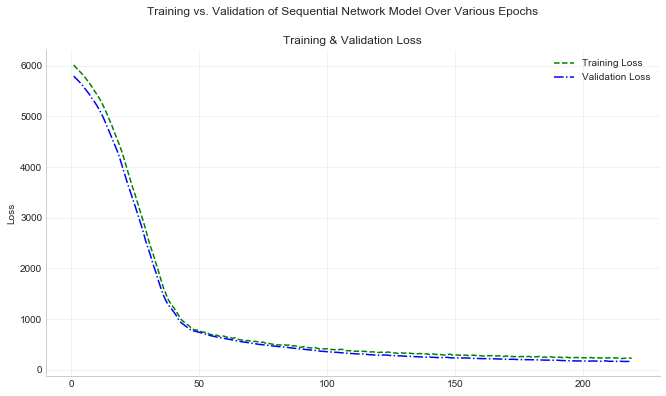

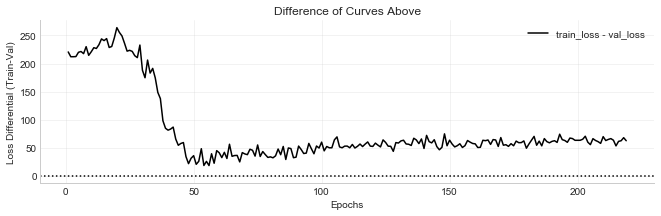

Epoch 00174: early stopping
Model ID: 045_0.0005_0.2_2_34
--------------------------------------------------------------------------------
R-squared on training data = 0.7406
R-squared on validation data = 0.7045
R-squared on testing data = 0.6760
--------------------------------------------------------------------------------
Epoch 00161: early stopping
Model ID: 046_0.005_0.3_2_34
--------------------------------------------------------------------------------
R-squared on training data = 0.7629
R-squared on validation data = 0.7117
R-squared on testing data = 0.6945
--------------------------------------------------------------------------------
Epoch 00137: early stopping
Model ID: 047_0.001_0.3_2_34
--------------------------------------------------------------------------------
R-squared on training data = 0.7113
R-squared on validation data = 0.6661
R-squared on testing data = 0.6391
--------------------------------------------------------------------------------
Epoch 00133: ea

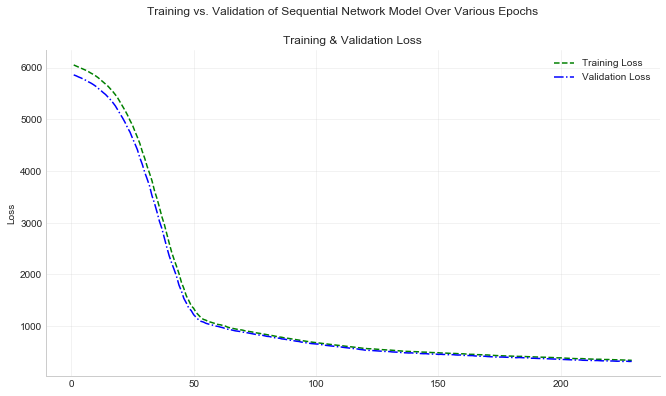

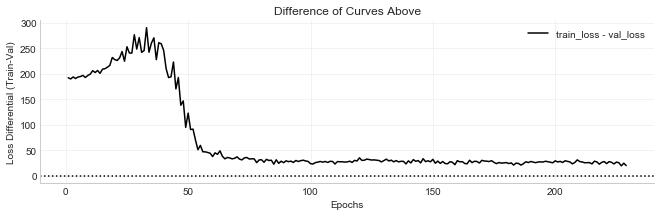

Epoch 00169: early stopping
Model ID: 050_0.001_0.0_3_16
--------------------------------------------------------------------------------
R-squared on training data = 0.8021
R-squared on validation data = 0.7600
R-squared on testing data = 0.7462
--------------------------------------------------------------------------------
Epoch 00155: early stopping
Model ID: 051_0.0005_0.0_3_16
--------------------------------------------------------------------------------
R-squared on training data = 0.7227
R-squared on validation data = 0.6424
R-squared on testing data = 0.6634
--------------------------------------------------------------------------------
Epoch 00124: early stopping
Model ID: 052_0.005_0.1_3_16
--------------------------------------------------------------------------------
R-squared on training data = 0.5744
R-squared on validation data = 0.4985
R-squared on testing data = 0.4902
--------------------------------------------------------------------------------
Epoch 00144: ea

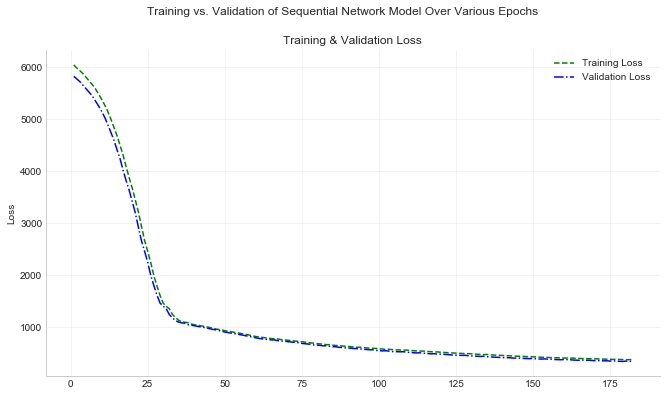

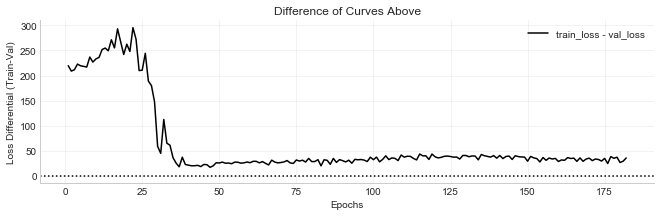

Epoch 00113: early stopping
Model ID: 062_0.001_0.0_3_22
--------------------------------------------------------------------------------
R-squared on training data = 0.7151
R-squared on validation data = 0.6537
R-squared on testing data = 0.6350
--------------------------------------------------------------------------------
Epoch 00163: early stopping
Model ID: 063_0.0005_0.0_3_22
--------------------------------------------------------------------------------
R-squared on training data = 0.8331
R-squared on validation data = 0.8059
R-squared on testing data = 0.7925
--------------------------------------------------------------------------------
Epoch 00134: early stopping
Model ID: 064_0.005_0.1_3_22
--------------------------------------------------------------------------------
R-squared on training data = 0.8195
R-squared on validation data = 0.7571
R-squared on testing data = 0.7734
--------------------------------------------------------------------------------
Epoch 00135: ea

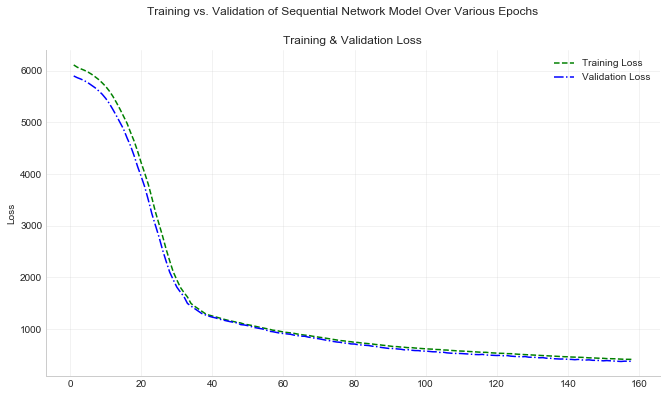

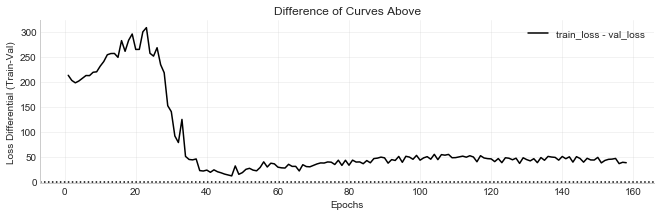

Epoch 00118: early stopping
Model ID: 074_0.001_0.0_3_28
--------------------------------------------------------------------------------
R-squared on training data = 0.8480
R-squared on validation data = 0.8045
R-squared on testing data = 0.8102
--------------------------------------------------------------------------------

                    Model # 74
                    Fully Connected Model w/ Dropout & Regularization 
                     - Regularizer Rate:    0.0010000
                     - Dropout Rate:        0.000
                     - Number Dense Layers: 2
                     - Neurons per Layer:   28
                     



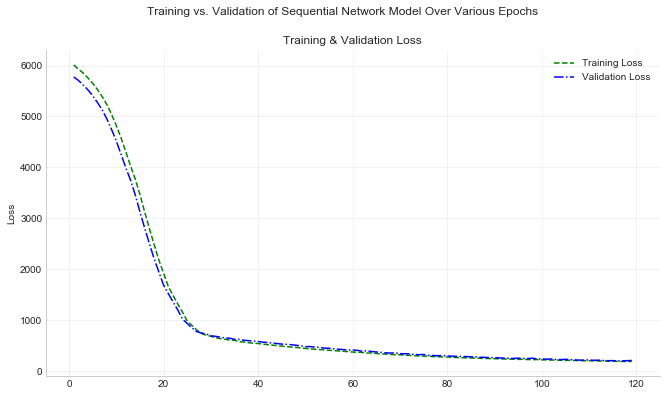

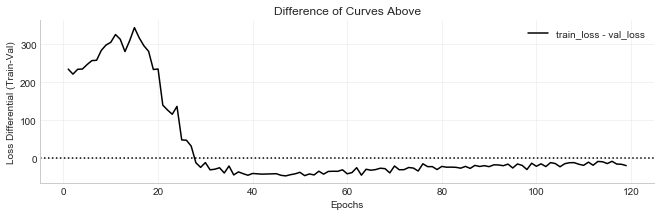

Epoch 00115: early stopping
Model ID: 075_0.0005_0.0_3_28
--------------------------------------------------------------------------------
R-squared on training data = 0.8184
R-squared on validation data = 0.7699
R-squared on testing data = 0.7781
--------------------------------------------------------------------------------
Epoch 00176: early stopping
Model ID: 076_0.005_0.1_3_28
--------------------------------------------------------------------------------
R-squared on training data = 0.9054
R-squared on validation data = 0.8819
R-squared on testing data = 0.8757
--------------------------------------------------------------------------------

                    Model # 76
                    Fully Connected Model w/ Dropout & Regularization 
                     - Regularizer Rate:    0.0050000
                     - Dropout Rate:        0.100
                     - Number Dense Layers: 2
                     - Neurons per Layer:   28
                     



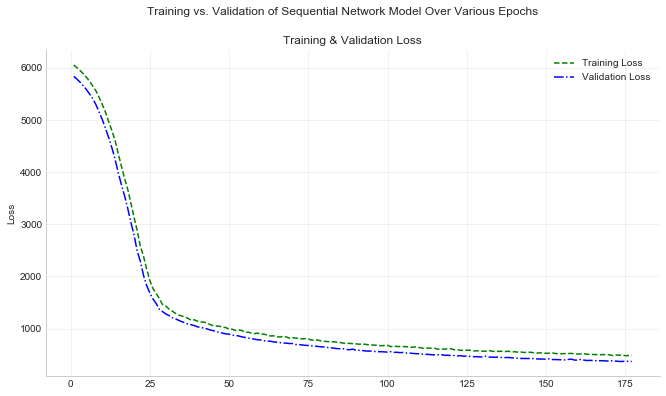

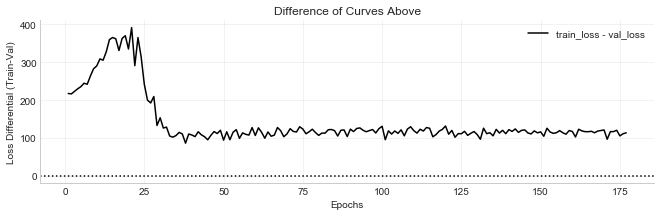

Epoch 00140: early stopping
Model ID: 077_0.001_0.1_3_28
--------------------------------------------------------------------------------
R-squared on training data = 0.8230
R-squared on validation data = 0.7802
R-squared on testing data = 0.7608
--------------------------------------------------------------------------------
Epoch 00114: early stopping
Model ID: 078_0.0005_0.1_3_28
--------------------------------------------------------------------------------
R-squared on training data = 0.7646
R-squared on validation data = 0.7233
R-squared on testing data = 0.7011
--------------------------------------------------------------------------------
Epoch 00101: early stopping
Model ID: 079_0.005_0.2_3_28
--------------------------------------------------------------------------------
R-squared on training data = 0.6034
R-squared on validation data = 0.5439
R-squared on testing data = 0.4978
--------------------------------------------------------------------------------
Epoch 00101: ea

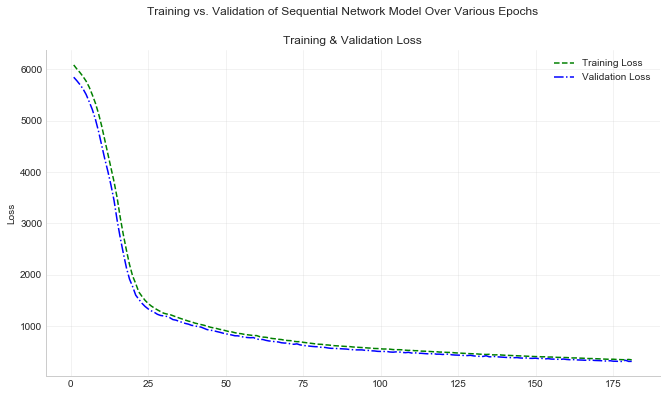

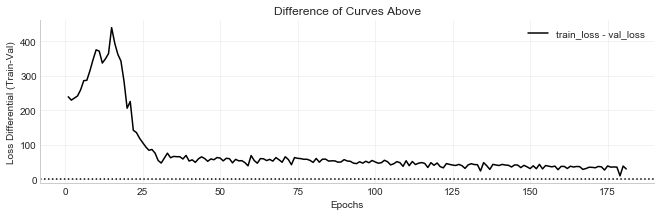

Epoch 00136: early stopping
Model ID: 086_0.001_0.0_3_34
--------------------------------------------------------------------------------
R-squared on training data = 0.8861
R-squared on validation data = 0.8665
R-squared on testing data = 0.8583
--------------------------------------------------------------------------------

                    Model # 86
                    Fully Connected Model w/ Dropout & Regularization 
                     - Regularizer Rate:    0.0010000
                     - Dropout Rate:        0.000
                     - Number Dense Layers: 2
                     - Neurons per Layer:   34
                     



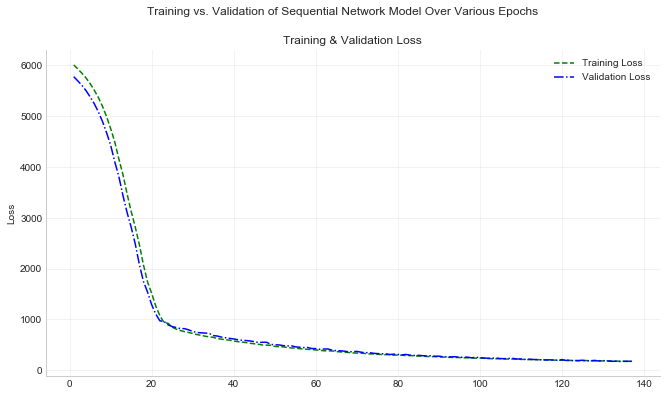

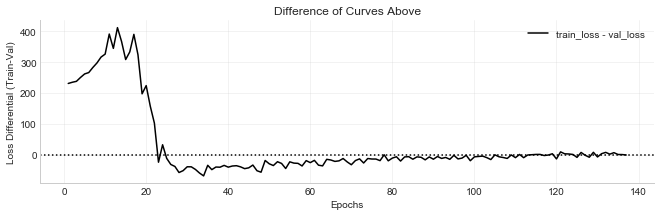

Epoch 00105: early stopping
Model ID: 087_0.0005_0.0_3_34
--------------------------------------------------------------------------------
R-squared on training data = 0.7843
R-squared on validation data = 0.7468
R-squared on testing data = 0.7304
--------------------------------------------------------------------------------
Epoch 00118: early stopping
Model ID: 088_0.005_0.1_3_34
--------------------------------------------------------------------------------
R-squared on training data = 0.7743
R-squared on validation data = 0.7574
R-squared on testing data = 0.7272
--------------------------------------------------------------------------------
Epoch 00092: early stopping
Model ID: 089_0.001_0.1_3_34
--------------------------------------------------------------------------------
R-squared on training data = 0.7428
R-squared on validation data = 0.7054
R-squared on testing data = 0.6808
--------------------------------------------------------------------------------
Epoch 00081: ea

In [ ]:
import tensorflow as tf
from keras import backend as K
import gc
K.clear_session()

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

from keras.models import *
from keras.layers import *
from keras.regularizers import *
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping

def simple_feedforward_model(num_neurons, num_dense_layers, reg=.001,
                            loss='mse', #test later mean_squared_logarithmic_error
                            activation='relu', optimizer='rmsprop',
                            metrics=None, dropout=.5, verbose=0):
    model = Sequential()
    model.add(Dense(num_neurons, activation=activation,
                    input_shape=(X_train.shape[1], ),
                    kernel_regularizer=l2(reg),
                    activity_regularizer=l1(reg)))

    for lyr in range(num_dense_layers):
        model.add(Dense(num_neurons,
                        activation=activation,
                        kernel_regularizer=l2(reg),
                        activity_regularizer=l1(reg)))
        model.add(Dropout(dropout))

    model.add(Dense(1))

    if verbose: model.summary()

    model.compile(optimizer=optimizer,
                 loss=loss,
                 metrics=metrics)

    return model

# instantiate model & run
epochs = 1000
num_batches = 4
batch_size = X_train.shape[0] // num_batches
verbose = 0
patience = 2

dropout_rates = np.arange(0, .31, .1)
n_units_per_layer = np.arange(16, 37, 6)
n_dense_layers = np.arange(1, 3, 1)
regularizer_range = [.005, .001, .0005]
r2_cutoff = 0.8

model_dict = dict()
model_number = 1
for layers in n_dense_layers:
    for units in n_units_per_layer:
        for dropout in dropout_rates:
            for reg in regularizer_range:
                # define feed forward model with parameters of CV
                model = simple_feedforward_model(units, layers, reg,
                                                 dropout=dropout)

                # use early stopping to ensure the model doesn't go too far
                # or waste time training un-fit models
                early_stopping = EarlyStopping(patience=patience,
                                              monitor='val_loss',
                                              min_delta=.0001,
                                              verbose=1,
                                              mode='auto')

                model_name = '''
                    Model # %i
                    Fully Connected Model w/ Dropout & Regularization
                     - Regularizer Rate:    %.7f
                     - Dropout Rate:        %.3f
                     - Number Dense Layers: %i
                     - Neurons per Layer:   %i
                    '''%(model_number, reg, dropout, layers, units)

                history = model.fit(X_train, y_train,
                                   epochs=epochs,
                                   batch_size=batch_size,
                                   verbose=verbose,
                                   validation_data=(X_val, y_val),
                                   callbacks=[early_stopping])

                test_pred = model.predict(X_test)
                test_r2 = r2_score(y_test, test_pred)
                val_pred = model.predict(X_val)
                val_r2 = r2_score(y_val, val_pred)
                train_pred = model.predict(X_train)
                train_r2 = r2_score(y_train, train_pred)

                actual_layers = layers + 1
                model_id = str(model_number).zfill(3)+'_'+str(reg)+'_'+str(round(dropout, 2))+'_'+str(actual_layers)+'_'+str(units)
                print('Model ID: {}'.format(model_id))
                print('-'*80)
                print('R-squared on training data = %.4f' % train_r2)
                print('R-squared on validation data = %.4f' % val_r2)
                print('R-squared on testing data = %.4f' % test_r2)
                print('-'*80)

                # only print data on reasonable models
                if test_r2 > r2_cutoff:
                    model_dict[model_id] = {'model_number': model_number,
                                           'model_id': model_name,
                                           'model': model,
                                           'r2_test': test_r2,
                                           'r2_val': val_r2,
                                           'r2_train': train_r2,
                                           'history': history.history,
                                           'units': units,
                                           'layers': actual_layers,
                                           'epochs': epochs,
                                           'dropout': dropout,
                                           'regularizer': reg}
                    print(model_name, '\n')
                    plot_loss(history.history)
                else:
                    model_dict[model_id] = {'model_number': model_number,
                       'model_id': model_name,
                       'model': model,
                       'r2_test': test_r2,
                       'r2_val': val_r2,
                       'r2_train': train_r2,
                       'history': None,
                       'units': units,
                       'layers': actual_layers,
                       'epochs': epochs,
                       'dropout': dropout,
                       'regularizer': reg}
                    pass

                model_number += 1

## Compile Findings from Grid Search

In [ ]:
model_df = pd.DataFrame.from_dict(model_dict).T
keep_cols = ['units', 'layers', 'dropout', 'regularizer',
            'r2_train', 'r2_val', 'r2_test']
model_df = model_df[keep_cols]
model_df.head()

units layers dropout regularizer  r2_train    r2_val  \
001_0.005_0.0_2_16     16      2       0       0.005  0.884869   0.86618   
002_0.001_0.0_2_16     16      2       0       0.001   0.87972  0.854546   
003_0.0005_0.0_2_16    16      2       0      0.0005  0.878691  0.850861   
004_0.005_0.1_2_16     16      2     0.1       0.005  0.711048  0.647206   
005_0.001_0.1_2_16     16      2     0.1       0.001  0.640311  0.587732   

                      r2_test  
001_0.005_0.0_2_16    0.85265  
002_0.001_0.0_2_16   0.850558  
003_0.0005_0.0_2_16  0.850518  
004_0.005_0.1_2_16   0.633054  
005_0.001_0.1_2_16     0.5569

## Plot the Train, Test and Validation `r2_score`

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000284D1A95198>,
      dtype=object)

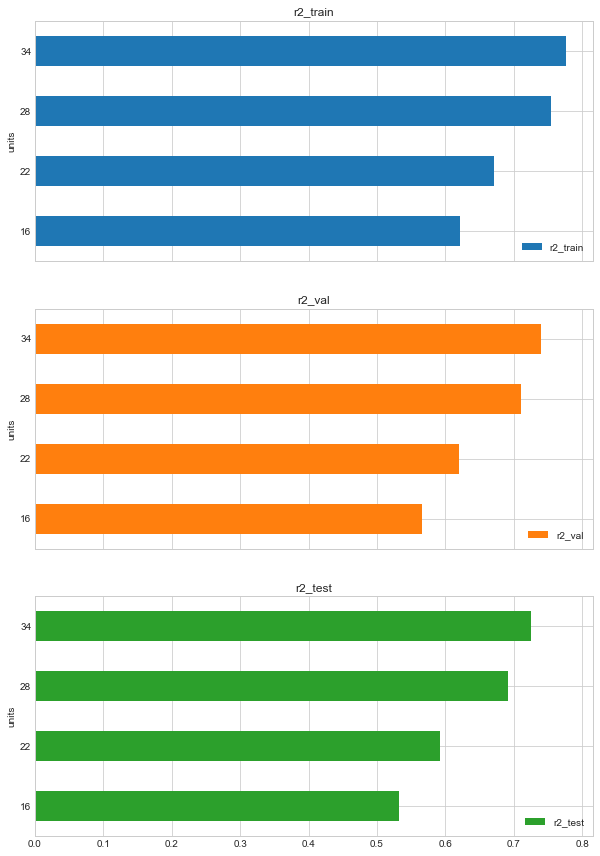

In [ ]:
r2_cols = ['r2_train', 'r2_val', 'r2_test']
model_df[r2_cols] = model_df[r2_cols].astype(np.float32)
model_df.groupby(['units'])[r2_cols].mean().plot(kind='barh', subplots=True,
                                                figsize=(10, 15))

## Identify the Best Model

Below the `pd.DataFrame.idxmax` function is used to identify the `model_id` that achieved the best testing results.

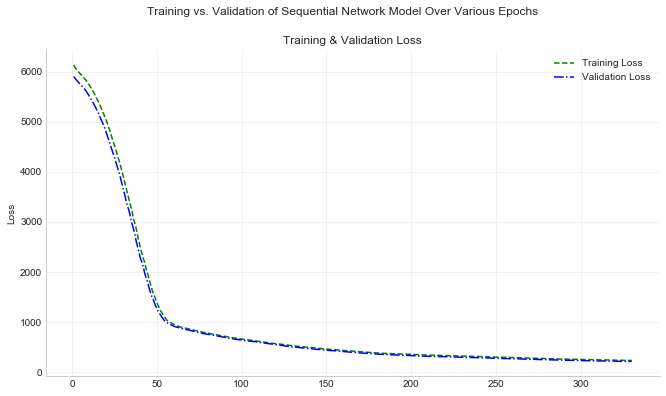

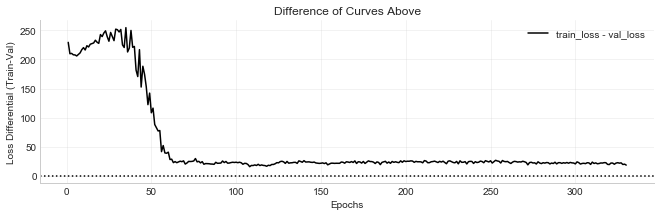

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 34)                1598      
_________________________________________________________________
dense_110 (Dense)            (None, 34)                1190      
_________________________________________________________________
dropout_37 (Dropout)         (None, 34)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 35        
Total params: 2,823
Trainable params: 2,823
Non-trainable params: 0
_________________________________________________________________


units                34
layers                2
dropout               0
regularizer       0.005
r2_train       0.956788
r2_val         0.938761
r2_test        0.945236
Name: 037_0.005_0.0_2_34, dtype: object

In [ ]:
best_model_ix = model_df['r2_test'].idxmax()
best_model = model_dict[best_model_ix]['model']
plot_loss(model_dict[best_model_ix]['history'])
plt.savefig('./figs/best_model_loss.png')
best_model.summary()
model_df.loc[best_model_ix]

In [ ]:
best_model.save('BEST_MODEL.h5')

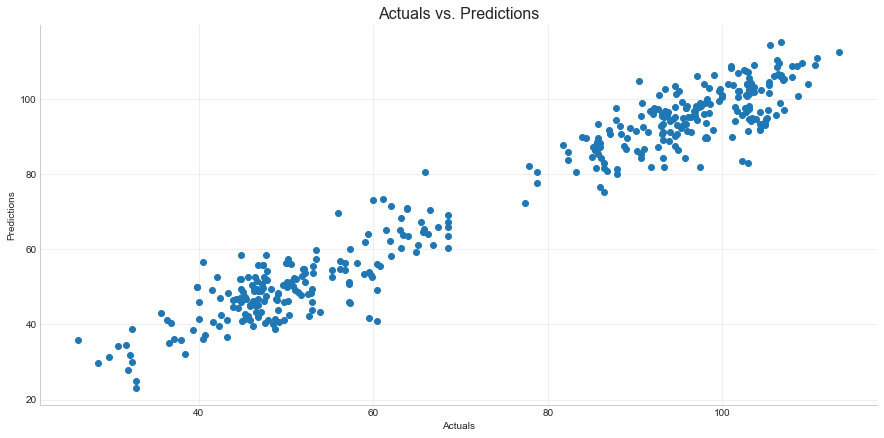

In [ ]:
pred = best_model.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(y_test, pred)
ax.grid(alpha=.4)
ax.set_xlabel('Actuals')
ax.set_ylabel('Predictions')
ax.set_title('Actuals vs. Predictions', size=16)
sns.despine()

We see here that a model that uses 22 units per layer, two layers (note that the first layer is not counted in the `num_layers` parameter), no dropout and an l1/l2 regularizer of 0.005.  The $R^2$ score for all data sets is very high, which should give cause for suspicion and further investigation.  

## Generate Predictions for Entire Dataset & Compare to Actuals

In [ ]:
def prep_solo_data(df, X_cols, y_col, norm_cols=None, window=window):
    X = df[X_cols]
    Y = df[y_col]
    std = StandardScaler()
    if norm_cols is not None:
        std.fit(X[norm_cols])
        X[norm_cols] = std.transform(X[norm_cols])
    else:
        std.fit(X)
        X = pd.DataFrame(std.transform(X),
                         index=X.index.values,
                         columns=X.columns)

    # Note:  smooth_df[y_col] is already shifted
    # back by -window

    return X, Y

X, Y = prep_solo_data(smooth_df, X_cols, y_col, norm_cols=norm_cols)

## Visualize Peredictions

In [ ]:
pred = best_model.predict(X.as_matrix()).reshape(-1)
pred = pd.DataFrame(pred, index=pd.to_datetime(X.index.values),
                   columns=['pred'])

pred_df = pred.join(Y, how='inner')
pred_df = pred_df.dropna()
pred_df.tail()

pred  dcoilwtico
2018-04-04  58.768600       68.56
2018-04-05  57.743031       68.56
2018-04-06  60.051060       68.56
2018-04-07  60.604538       68.56
2018-04-08  61.832554       68.56

# Final Results

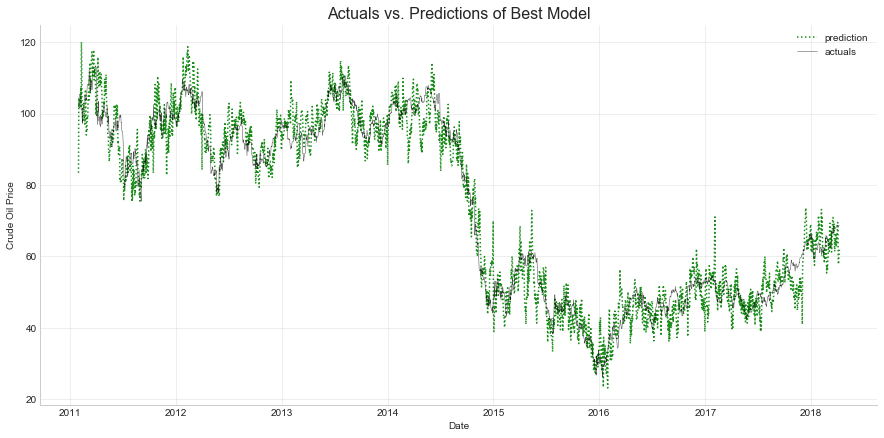

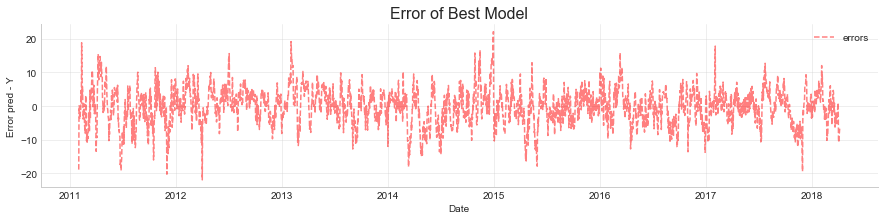


R-squared on entire dataset:  0.9540



In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(pred_df.index.values, pred_df['pred'], label='prediction',
        linestyle=':', color='green', alpha=.9)
ax.plot(pred_df.index.values, pred_df[y_col], label='actuals',
        color='black', alpha=.7, linewidth=.5)
ax.grid(alpha=.4)
ax.set_xlabel('Date')
ax.set_ylabel('Crude Oil Price')
ax.set_title('Actuals vs. Predictions of Best Model', size=16)
ax.legend(loc='best')
sns.despine()

fig, ax = plt.subplots(figsize=(15, 3))
errors = np.subtract(pred_df['pred'], pred_df[y_col])
ax.plot(pred_df.index.values, errors, label='errors',
        linestyle='--', color='red', alpha=.5)
ax.grid(alpha=.4)
ax.set_xlabel('Date')
ax.set_ylabel('Error pred - Y')
ax.set_title('Error of Best Model', size=16)
ax.legend(loc='best')
sns.despine()

plt.show()

r2_final = r2_score(pred_df['pred'], pred_df[y_col])
print('''
R-squared on entire dataset:  %.4f
''' %r2_final)

***Since a seed was not set during train test split these numbers may change***